# imports

In [1]:
import findspark
findspark.init('D:\spark\spark-2.3.2-bin-hadoop2.7')

from pyspark.sql import *
from pyspark import SparkContext
from pyspark.mllib.regression import LabeledPoint
import numpy as np
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.tree import GradientBoostedTrees



# spark Session

In [2]:
spark = SparkSession.builder.getOrCreate()

df = spark.sql('''select 'spark' as hello ''')
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



# spark context for files

In [3]:
sc = SparkContext.getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Reading csv files

In [4]:
hourData = sc.textFile("hour_noheader.csv")
dayData = sc.textFile("day.csv")
dayData

day.csv MapPartitionsRDD[8] at textFile at <unknown>:0

In [5]:
data = hourData.map(lambda line: line.split(","))
data
line_1 = data.first()
line_1

['1',
 '2011-01-01',
 '1',
 '0',
 '1',
 '0',
 '0',
 '6',
 '0',
 '1',
 '0.24',
 '0.2879',
 '0.81',
 '0',
 '3',
 '13',
 '16']

In [6]:
def mapping(col, iD):
    return col.map(lambda line: line[iD]).distinct().zipWithIndex().collectAsMap()

In [7]:
print ("Mapping of first categorical feasture column: %s" % (mapping(data, 2)))

Mapping of first categorical feasture column: {'1': 0, '4': 1, '2': 2, '3': 3}


In [8]:
mappingsData = [mapping(data, x) for x in range(2,10)]
vetLen = sum(map(len, mappingsData))
numLen = len(data.first()[11:15])
total = numLen + vetLen

In [9]:
print ("Feature vector length for categorical features: %d " % vetLen)
print ("Feature vector length for numerical features: %d " % numLen)
print ("Total feature vector length: %d " % total)

Feature vector length for categorical features: 57 
Feature vector length for numerical features: 4 
Total feature vector length: 61 


In [10]:
def features(data):
    vecCatLen = np.zeros(vetLen)
    x = 0
    step = 0
    for line in data[2:9]:
        mAp = mappingsData[x]
        iD = mAp[line]
        vecCatLen[iD + step] = 1
        x = x + 1
        step = step + len(mAp)
    vecNumLen = np.array([float(line) for line in data[10:14]])
    return np.concatenate((vecCatLen, vecNumLen))

def label(data):
    return float(data[-1])

features(data.first())

array([1.    , 0.    , 0.    , 0.    , 1.    , 0.    , 1.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 1.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 1.    , 0.    , 0.    , 0.    , 0.    , 1.    ,
       0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.24  , 0.2879, 0.81  , 0.    ])

In [11]:
dataNew = data.map(lambda row: LabeledPoint(label(row), features(row)))
dataNew

PythonRDD[66] at RDD at PythonRDD.scala:52

In [12]:
newLine_1 = dataNew.first()
newLine_1

LabeledPoint(16.0, [1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0])

In [13]:
print ("Raw Data" + str(line_1[2:]))

print ("Label:" + str(newLine_1.label))

print ("Linear Model feature vector:\n" + str(newLine_1.features))

print ("Linear Model feature vector length: " + str(len(newLine_1.features)))

Raw Data['1', '0', '1', '0', '0', '6', '0', '1', '0.24', '0.2879', '0.81', '0', '3', '13', '16']
Label:16.0
Linear Model feature vector:
[1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]
Linear Model feature vector length: 61


# Decision Tree. 

In [14]:
def featuresDT(data):
    return np.array(list(map(float, data[2:14])))


dataNewDT = data.map(lambda row: LabeledPoint(label(row), featuresDT(row)))

dataNewDT.count()

point_1_dt = dataNewDT.first()

print ("Decision Tree feature vector: "  + str(point_1_dt.features))

print ("Decision Tree feature vector length:" + str(len(point_1_dt.features)))

Decision Tree feature vector: [1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0]
Decision Tree feature vector length:12


In [15]:
dataNewDT.__dict__


{'func': <function pyspark.rdd.PipelinedRDD.__init__.<locals>.pipeline_func(split, iterator)>,
 'preservesPartitioning': False,
 '_prev_jrdd': JavaObject id=o29,
 '_prev_jrdd_deserializer': UTF8Deserializer(True),
 'is_cached': False,
 'is_checkpointed': False,
 'ctx': <SparkContext master=local[*] appName=pyspark-shell>,
 'prev': PythonRDD[70] at RDD at PythonRDD.scala:52,
 '_jrdd_val': None,
 '_id': None,
 '_jrdd_deserializer': AutoBatchedSerializer(PickleSerializer()),
 '_bypass_serializer': False,
 'partitioner': None}

In [16]:
linearModel = LinearRegressionWithSGD.train(dataNew, iterations=10, step=0.1, intercept=False)
linearModel

(weights=[3.3144115781658394,12.734752762697337,13.869421452255626,16.857502533637312,13.045454848254282,33.730633478501844,0.545990902670924,3.7951896813264177,5.57014088759232,5.698747782214591,5.227854841855272,2.270220936076588,1.1140362255411778,2.735609036197668,5.2056189563454,5.6553423011491315,5.387480141110341,3.569856634676279,-0.8608744230912329,-1.28183393183467,-1.7817209305523372,5.490522547320561,2.580624686846815,1.6289668745035646,3.2887019895428766,3.0295121883445417,4.518462048105712,7.643287141022094,4.500822941565794,2.7215469373133234,1.6027764691405157,0.7499347148067798,-1.4831037059634251,-1.6739972713511768,-1.5463459086913076,-0.39350799059991726,2.4357274517345484,2.345521139866199,3.2980095879861917,3.2432593465068877,6.8753820502965555,-0.15558562606278592,45.40524838674942,1.3708399400067088,6.368139189481729,6.359053373778718,6.890694358482135,7.308593282112572,6.426534813671129,6.4781589062650635,6.944914402964768,15.04757241160101,31.7285159151551,0.0

In [17]:
predictedVStrue = dataNew.map(lambda line: (line.label, linearModel.predict(line.features)))
predictedVStrue
print ("predictions of Tree: " + str(predictedVStrue.take(5)))

predictions of Tree: [(16.0, 117.89250386724846), (40.0, 116.2249612319211), (32.0, 116.02369145779235), (13.0, 115.67088016754433), (1.0, 115.56315650834317)]


# Tree predictions

In [18]:
modelDT = DecisionTree.trainRegressor(dataNewDT,{})

predictionModel = modelDT.predict(dataNewDT.map(lambda x: x.features))

actualModel = dataNew.map(lambda x: x.label)

predictedVStrueDT = actualModel.zip(predictionModel)

print ("predictions of Tree: " + str(predictedVStrueDT.take(5)))

print ("depth of Tree: " + str(modelDT.depth()))

print ("number of nodes for Tree: " + str(modelDT.numNodes()))

predictions of Tree: [(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945), (13.0, 14.284023668639053), (1.0, 14.284023668639053)]
depth of Tree: 5
number of nodes for Tree: 63


# Error Functions

In [19]:
def errorSquared(actualModel, predictionModel):
    return (predictionModel - actualModel)**2

def errorABS(actualModel, predictionModel):
    return np.abs(predictionModel - actualModel)

def errorSquaredLog(predictionModel, actualModel):
    return (np.log(predictionModel + 1) - np.log(actualModel + 1))**2

# Linear Model

In [20]:
mean_squared_error = predictedVStrue.map(lambda args: errorSquared(args[0], args[1])).mean()

mean_absolute_error = predictedVStrue.map(lambda args: errorABS(args[0], args[1])).mean()

root_mean_squared_log_error = np.sqrt(predictedVStrue.map(lambda args: errorSquaredLog(args[0], args[1])).mean())

print ("Mean Squared Error: %2.4f" % mean_squared_error)

print ("Mean Absolute Error: %2.4f" % mean_absolute_error)

print ("Root Mean Squared Log Error: %2.4f" % root_mean_squared_log_error)

Mean Squared Error: 30679.4539
Mean Absolute Error: 130.6429
Root Mean Squared Log Error: 1.4653


# Decision Tree

In [21]:
mean_squared_error_dt = predictedVStrueDT.map(lambda args: errorSquared(args[0], args[1])).mean()

mean_absolute_error_dt = predictedVStrueDT.map(lambda args: errorABS(args[0], args[1])).mean()

root_mean_squared_log_error_dt = np.sqrt(predictedVStrueDT.map(lambda args: errorSquaredLog(args[0], args[1])).mean())

print ("Mean Squared Error: %2.4f" % mean_squared_error_dt)

print ("Mean Absolute Error: %2.4f" % mean_absolute_error_dt)

print ("Root Mean Squared Log Error: %2.4f" % root_mean_squared_log_error_dt)



Mean Squared Error: 11611.4860
Mean Absolute Error: 71.1502
Root Mean Squared Log Error: 0.6251


# matplotlib

In [22]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


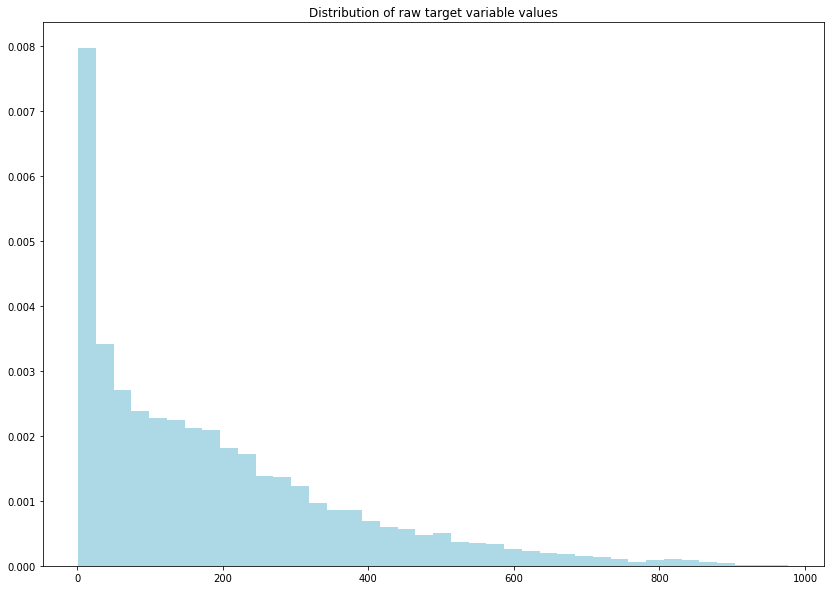

In [23]:
targets = data.map(lambda row: float(row[-1])).collect()

hist(targets, bins=40, color="lightblue", density=True)

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.title('Distribution of raw target variable values')

fig.set_size_inches(14, 10)

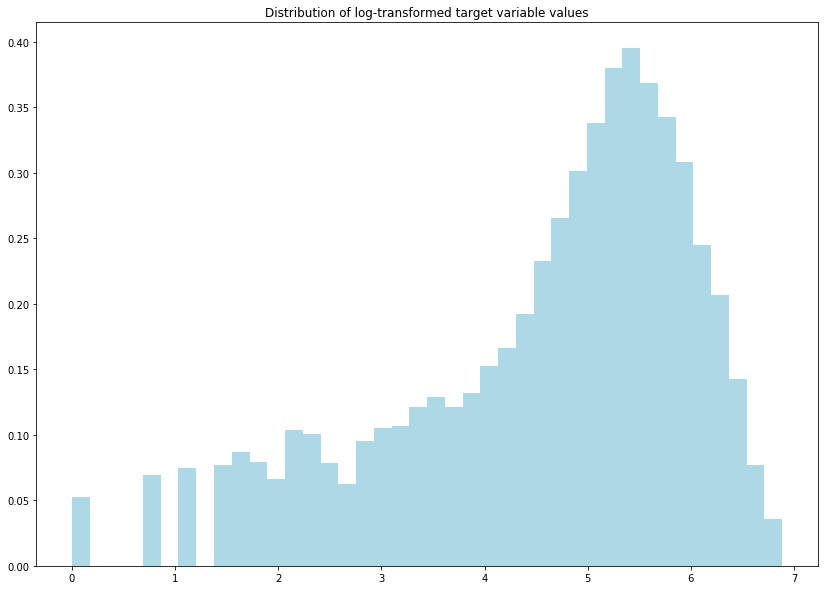

In [24]:

targetsLog = data.map(lambda row: np.log(float(row[-1]))).collect()

hist(targetsLog, bins=40, color="lightblue", density=True)
matplotlib.pyplot.title('Distribution of log-transformed target variable values')

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(14, 10)

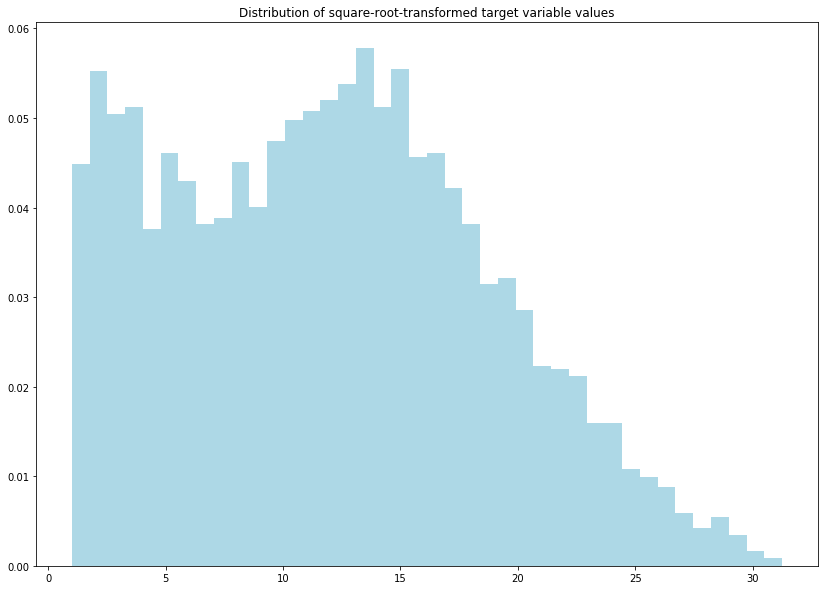

In [25]:

targetsSquare = data.map(lambda row: np.sqrt(float(row[-1]))).collect()

hist(targetsSquare, bins=40, color="lightblue", density=True)

matplotlib.pyplot.title('Distribution of square-root-transformed target variable values')

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(14, 10)

# Log Transformed Targets

In [26]:
dataNewLog = dataNew.map(lambda lp: LabeledPoint(np.log(lp.label), lp.features))

modelNewlog = LinearRegressionWithSGD.train(dataNewLog, iterations=10, step=0.1)

predictedVStrueLog = dataNewLog.map(lambda p: (np.exp(p.label), np.exp(modelNewlog.predict(p.features))))

In [27]:
mean_squared_error_log = predictedVStrueLog.map(lambda args: errorSquared(args[0], args[1])).mean()

mean_absolue_error_log = predictedVStrueLog.map(lambda args: errorABS(args[0], args[1])).mean()

root_mean_squared_error_log = np.sqrt(predictedVStrueLog.map(lambda args: errorSquaredLog(args[0], args[1])).mean())


print ("Mean Squared Error For Log Transform: %2.4f" % mean_squared_error_log)

print ("Mean Absolue Error For Log Transform: %2.4f" % mean_absolue_error_log)

print ("Root Mean Squared Log Error For Log Transform: %2.4f" % root_mean_squared_error_log)

print ("Non log-transformed predictions For Log Transform:\n " + str(predictedVStrue.take(3)))

print ("Log-transformed predictions For Log Transform:\n" + str(predictedVStrueLog.take(3)))

Mean Squared Error For Log Transform: 50685.5559
Mean Absolue Error For Log Transform: 155.2955
Root Mean Squared Log Error For Log Transform: 1.5411
Non log-transformed predictions For Log Transform:
 [(16.0, 117.89250386724846), (40.0, 116.2249612319211), (32.0, 116.02369145779235)]
Log-transformed predictions For Log Transform:
[(15.999999999999998, 28.080291845456212), (40.0, 26.959480191001784), (32.0, 26.65472562945802)]


# log analysis for Decision tree

In [28]:

dataLogDT = dataNewDT.map(lambda lp: LabeledPoint(np.log(lp.label), lp.features))

dataLogDT

dtModelLog = DecisionTree.trainRegressor(dataLogDT,{})

predictionLog = dtModelLog.predict(dataLogDT.map(lambda p: p.features))

actualLog = dataLogDT.map(lambda p: p.label)

predictedVStrueDTLog = actualLog.zip(predictionLog).map(lambda args: (np.exp(args[0]), np.exp(args[1])))

In [29]:
mean_squared_error_log_dt = predictedVStrueDTLog.map(lambda args: errorSquared(args[0], args[1])).mean()

mean_absolue_error_log_dt = predictedVStrueDTLog.map(lambda args: errorABS(args[0], args[1])).mean()

root_mean_squared_error_log_dt = np.sqrt(predictedVStrueDTLog.map(lambda args: errorSquaredLog(args[0], args[1])).mean())

print ("Mean Squared Error For log analysis: %2.4f" % mean_squared_error_log_dt)

print ("Mean Absolue Error For log analysis: %2.4f" % mean_absolue_error_log_dt)

print ("Root Mean Squared Log Error For log analysis: %2.4f" % root_mean_squared_error_log_dt)

print ("Non log-transformed predictions For log analysis:\n" + str(predictedVStrueDT.take(3)))

print ("Log-transformed predictions For log analysis:\n " + str(predictedVStrueDTLog.take(3)))

Mean Squared Error For log analysis: 14781.5760
Mean Absolue Error For log analysis: 76.4131
Root Mean Squared Log Error For log analysis: 0.6406
Non log-transformed predictions For log analysis:
[(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945)]
Log-transformed predictions For log analysis:
 [(15.999999999999998, 37.53077978715451), (40.0, 37.53077978715451), (32.0, 7.279707099390729)]


# Gradient Boosted Tree

In [30]:
dataIDx = dataNew.zipWithIndex().map(lambda args: (args[1], args[0]))

test = dataIDx.sample(False, 0.2, 42)

train = dataIDx.subtractByKey(test)

trainData = train.map(lambda args: args[1])

testData = test.map(lambda args: args[1])

trainSize = trainData.count()
testSize = testData.count()

print ("Training data size: %d" % trainSize)

print ("Test data size: %d" % testSize)

print ("Total data size: %d " % (trainSize + testSize))

Training data size: 13869
Test data size: 3510
Total data size: 17379 


# Data Split into training and testing

In [31]:
dataIDxDT = dataNewDT.zipWithIndex().map(lambda args: (args[1], args[0]))

testDT = dataIDxDT.sample(False, 0.2, 42)

trainDT = dataIDxDT.subtractByKey(testDT)

trainDataDT = trainDT.map(lambda args: args[1])

testDataDT = testDT.map(lambda args: args[1])


In [32]:
gradientBoostedTreeModel = GradientBoostedTrees.trainRegressor(dataNewDT,categoricalFeaturesInfo={}, numIterations=3)
gradientBoostedTreeModel

TreeEnsembleModel regressor with 3 trees

In [33]:
predictionsGradient = gradientBoostedTreeModel.predict(dataNewDT.map(lambda p: p.features))

actualGradient = dataNew.map(lambda p: p.label)

predictedVStrueGradient = actualGradient.zip(predictionsGradient)

print ("predictions for Gradient Boosted Tree: " + str(predictedVStrueGradient.take(5)))

print ("Tree depth for Gradient Boosted Tree: " + str(gradientBoostedTreeModel.numTrees()))

print ("number of nodes for Gradient Boosted Tree: " + str(gradientBoostedTreeModel.totalNumNodes()))

## Error rates for Gradient Boosted Trees

mean_squared_error_gradient_dt = predictedVStrueGradient.map(lambda args: errorSquared(args[0], args[1])).mean()

mean_absolute_error_gradient_dt = predictedVStrueGradient.map(lambda args: errorABS(args[0], args[1])).mean()

root_mean_squarede_error_gradient_dt = np.sqrt(predictedVStrueGradient.map(lambda args: errorSquaredLog(args[0], args[1])).mean())

print ("Mean Squared Error - Gradient Boosted Tree: %2.4f" % mean_squared_error_gradient_dt)

print ("Mean Absolute Error - Gradient Boosted Tree: %2.4f" % mean_absolute_error_gradient_dt)

print ("Root Mean Squared Log Error - Gradient Boosted Tree: %2.4f" % root_mean_squarede_error_gradient_dt)

predictions for Gradient Boosted Tree: [(16.0, 46.167216204732135), (40.0, 46.167216204732135), (32.0, 17.808113781421504), (13.0, 17.808113781421504), (1.0, 17.808113781421504)]
Tree depth for Gradient Boosted Tree: 3
number of nodes for Gradient Boosted Tree: 45
Mean Squared Error - Gradient Boosted Tree: 13698.5518
Mean Absolute Error - Gradient Boosted Tree: 81.1557
Root Mean Squared Log Error - Gradient Boosted Tree: 0.7801


# Gradient boost tree iterations

In [34]:
# Gradient boost tree iterations 

def gradientEvaluate(train, test, maxDepth, maxBins):
    gradientModel = GradientBoostedTrees.trainRegressor(
        train, categoricalFeaturesInfo={},
        numIterations=2,
        maxDepth=maxDepth, maxBins=maxBins
    )
    predictionGradient = gradientModel.predict(test.map(lambda p: p.features))
    actualGradient = test.map(lambda p: p.label)
    testPrediction = actualGradient.zip(predictionGradient)
    root_mean_squarede_error = np.sqrt(testPrediction.map(lambda args: errorSquaredLog(args[0], args[1])).mean())
    return root_mean_squarede_error

# Gradient Boosted Tree Depth

D:\spark\spark-2.3.2-bin-hadoop2.7\python\pyspark\statcounter.py:80: RuntimeWarning: invalid value encountered in maximum
  self.maxValue = maximum(self.maxValue, other.maxValue)
D:\spark\spark-2.3.2-bin-hadoop2.7\python\pyspark\statcounter.py:81: RuntimeWarning: invalid value encountered in minimum
  self.minValue = minimum(self.minValue, other.minValue)


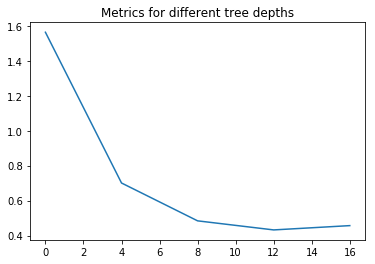

In [35]:
matplotlib.pyplot.title('Metrics for different tree depths')
params = [0, 4, 8, 12, 16, 20]

metrics = [gradientEvaluate(trainDataDT, testDataDT, param, 32) for param in params]

plot(params, metrics)

fig = matplotlib.pyplot.gcf()

# Gradient Boosted Tree Maximum bins

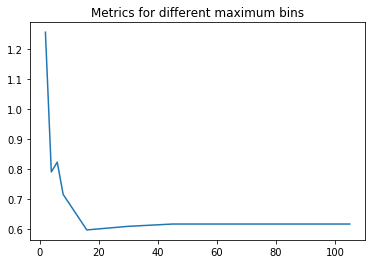

In [54]:
params = [2, 4, 6, 8, 16, 30, 45, 60, 75, 90, 105]

metrics = [gradientEvaluate(trainDataDT, testDataDT, 5, param) for param in params]

plot(params, metrics)

matplotlib.pyplot.title('Metrics for different maximum bins')

fig = matplotlib.pyplot.gcf()


# Linear Models

In [59]:
def evaluate(train, test, iterations, step, regParam, regType, intercept):
    linearModel = LinearRegressionWithSGD.train(
        train, iterations, step, regParam=regParam, 
        regType=regType, intercept=intercept
    )
    predictionLinear = linearModel.predict(test.map(lambda p: p.features))
    actualLinear = test.map(lambda p: p.label)
    testPrediction = actualLinear.zip(predictionLinear)
    rmsle = np.sqrt(testPrediction.map(lambda args: errorSquaredLog(args[0], args[1])).mean())
    return rmsle


# Comparision with diff iterations

org.apache.spark.api.java.JavaPairRDD@1d52327
org.apache.spark.api.java.JavaPairRDD@150d3e2
org.apache.spark.api.java.JavaPairRDD@252306
org.apache.spark.api.java.JavaPairRDD@1254ded
org.apache.spark.api.java.JavaPairRDD@13b494
org.apache.spark.api.java.JavaPairRDD@10b0590


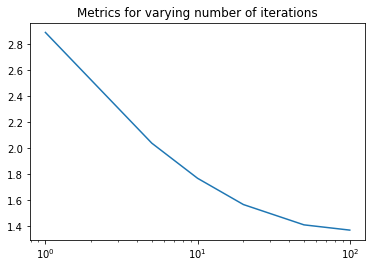

In [56]:
params = [1, 5, 10, 20, 50, 100]

metrics = [evaluate(trainData, testData, param, 0.01, 0.0, "l2", False) for param in params]

plot(params, metrics)

fig = matplotlib.pyplot.gcf()

matplotlib.pyplot.title('Metrics for varying number of iterations')

pyplot.xscale("log")

# Performing same test, changing the step size

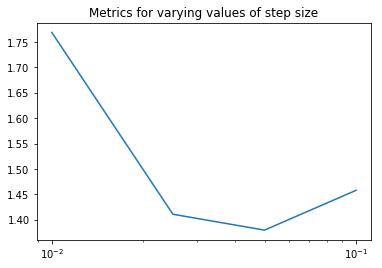

In [60]:
params = [0.01, 0.025, 0.05, 0.1, 1.0]

metrics = [evaluate(trainData, testData, 10, param, 0.0, "l2", False) for param in params]

plot(params, metrics)

fig = matplotlib.pyplot.gcf()

matplotlib.pyplot.title('Metrics for varying values of step size')

pyplot.xscale("log")

# Regularization

org.apache.spark.api.java.JavaPairRDD@1db26eb
org.apache.spark.api.java.JavaPairRDD@1e37838
org.apache.spark.api.java.JavaPairRDD@397364
org.apache.spark.api.java.JavaPairRDD@1d10ba5
org.apache.spark.api.java.JavaPairRDD@cf7493
org.apache.spark.api.java.JavaPairRDD@154c39e
org.apache.spark.api.java.JavaPairRDD@7e65f5


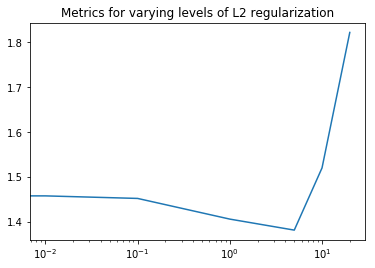

In [58]:

params = [0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]

metrics = [evaluate(trainData, testData, 10, 0.1, param, "l1", False) for param in params]

plot(params, metrics)

matplotlib.pyplot.title('Metrics for varying levels of L2 regularization')

fig = matplotlib.pyplot.gcf()

pyplot.xscale("log")


# Regularization using sparse weight vectors

In [62]:

model_regType11 = LinearRegressionWithSGD.train(trainData, 10, 0.1, regParam=1.0, regType="l1", intercept=False)

model_regType11_regParam10 = LinearRegressionWithSGD.train(trainData, 10, 0.1, regParam=10.0, regType="l1", intercept=False)

model_regType11_regParam100 = LinearRegressionWithSGD.train(trainData, 10, 0.1, regParam=100.0, regType="l1", intercept=False)

print ("number of zero weights regularization: " + str(sum(model_regType11.weights.array == 0)))

print ("number of zeros weights regularization (10): " + str(sum(model_regType11_regParam10.weights.array == 0)))

print ("number of zeros weights regularization (100): " +str(sum(model_regType11_regParam100.weights.array == 0)))

number of zero weights regularization: 5
number of zeros weights regularization (10): 33
number of zeros weights regularization (100): 58


# Intercept

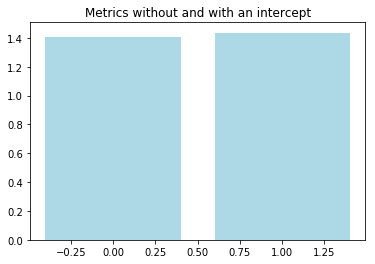

In [63]:

params = [False, True]

metrics = [evaluate(trainData, testData, 10, 0.1, 1.0, "l2", param) for param in params]

bar(params, metrics, color="lightblue")

matplotlib.pyplot.title('Metrics without and with an intercept')

fig = matplotlib.pyplot.gcf()


# impact of parameter on Decision Tree

In [72]:

def evaluateDT(train, test, maxDepth, maxBins):
    modelDT = DecisionTree.trainRegressor(
        train, {}, impurity="variance", 
        maxDepth=maxDepth, 
        maxBins=maxBins
    )
    prediction = modelDT.predict(test.map(lambda p: p.features))
    actual = test.map(lambda p: p.label)
    testPrediction = actual.zip(prediction)
    root_mean_squarede_error = np.sqrt(testPrediction.map(lambda args: errorSquaredLog(args[0], args[1])).mean())
    return root_mean_squarede_error

# Tree Depth

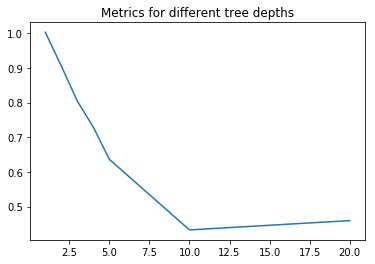

In [73]:

params = [1, 2, 3, 4, 5, 10, 20]

metrics = [evaluateDT(trainDataDT, testDataDT, param, 32) for param in params]

plot(params, metrics)

matplotlib.pyplot.title('Metrics for different tree depths')

fig = matplotlib.pyplot.gcf()


# Maximum bins

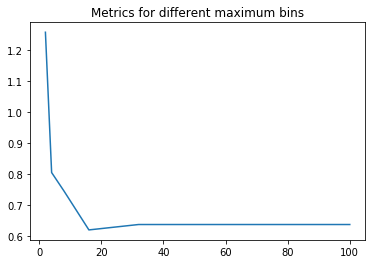

In [75]:

params = [2, 4, 8, 16, 32, 64, 100]

metrics = [evaluateDT(trainDataDT, testDataDT, 5, param) for param in params]

plot(params, metrics)

matplotlib.pyplot.title('Metrics for different maximum bins')

fig = matplotlib.pyplot.gcf()
